# Etude du trafic emails

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.express as px

from datetime import timedelta, datetime, date
from time import gmtime,strftime

from pandas.api.types import CategoricalDtype
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
# Chargement des données
dateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y")
data = pd.read_csv('data_email_heure_BAL.csv', sep=';', \
                   parse_dates=['date_txt'], date_parser=dateparser)
data.columns = ['canal', 'date', 'heure_txt', 'BAL', 'nb_emails_reçus']

mois_ord = CategoricalDtype(categories=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], ordered=True)
jour_ord = CategoricalDtype(categories=['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi',
                                        'dimanche'], ordered=True)

In [4]:
# Dataframe cumul par jour toutes BAL
df_jour = data.groupby('date').aggregate({'nb_emails_reçus': sum})
# Dataframe cumul par semaine toutes BAL
df_sem = df_jour.resample('W').sum()
# Dataframe cumul par mois toutes BAL
df_mois = df_jour.resample('M').sum()

df_mois.reset_index(inplace=True)
df_mois['année'] = [d.year for d in df_mois.date]
df_mois['mois'] = [d.strftime('%b') for d in df_mois.date]
# Pour tri par valeur chronologique
df_mois['mois_tri'] = df_mois['mois'].astype(mois_ord)
years = df_mois['année'].unique()

df_sem.reset_index(inplace=True)
df_sem['année'] = [d.year for d in df_sem.date]
df_sem['mois'] = [d.strftime('%b') for d in df_sem.date]
df_sem['semaine'] = [d.strftime('%W') for d in df_sem.date]
df_sem['semaine'] = df_sem['semaine'].astype('int64') + 1

df_jour.reset_index(inplace=True)
df_jour['année'] = [d.year for d in df_jour.date]
df_jour['mois'] = [d.strftime('%b') for d in df_jour.date]
df_jour['semaine'] = [d.strftime('%W') for d in df_jour.date]
df_jour['semaine'] = df_jour['semaine'].astype('int64') + 1
df_jour['no_jour'] = [d.strftime('%j') for d in df_jour.date]
df_jour['jour'] = df_jour.date.dt.day_name(locale = 'French').str.lower()
# Pour tri par valeur chronologique
df_jour['mois_tri'] = df_jour['mois'].astype(mois_ord)
df_jour['jour_tri'] = df_jour['jour'].astype(jour_ord)

In [5]:
# Constitution des dataframes par BAL

bals = data['BAL'].unique()
bals = bals.astype('str')

# Dataframe cumul par jour / BAL
df_jour_BAL = data.groupby(['date', 'BAL']).aggregate({'nb_emails_reçus': sum})

df_jour_BAL.reset_index(inplace=True)
df_jour_BAL['année'] = [d.year for d in df_jour_BAL.date]
df_jour_BAL['mois'] = [d.strftime('%b') for d in df_jour_BAL.date]
df_jour_BAL['semaine'] = [d.strftime('%W') for d in df_jour_BAL.date]
df_jour_BAL['semaine'] = df_jour_BAL['semaine'].astype('int64') + 1
df_jour_BAL['no_jour'] = [d.strftime('%j') for d in df_jour_BAL.date]
df_jour_BAL['jour'] = df_jour_BAL.date.dt.day_name(locale = 'French').str.lower()
# Pour tri par valeur chronologique
df_jour_BAL['mois_tri'] = df_jour_BAL['mois'].astype(mois_ord)
df_jour_BAL['jour_tri'] = df_jour_BAL['jour'].astype(jour_ord)

bals_bcom = bals[np.where(np.char.find(np.char.lower(bals), 'b_com') >= 0)]
bals_pdm = bals[np.where(np.char.find(np.char.lower(bals), 'b_com') == -1)]
type_bals = ['BCOM', 'PDM']

# Ajout tag BAL BCOM / BAL PDM
df_jour_BAL['type_BAL'] = np.where(df_jour_BAL['BAL'].isin(bals_bcom), 'BCOM', 'PDM')

# Dataframe cumul par semaine / BAL
df_sem_BAL = df_jour_BAL.groupby(['année', 'semaine', 'BAL', 'type_BAL']).aggregate({'nb_emails_reçus': sum})

# Dataframe cumul par mois / BAL
df_mois_BAL = df_jour_BAL.groupby(['année', 'mois_tri', 'BAL']).aggregate({'nb_emails_reçus': sum})

In [6]:
# Constitution des dataframes par type de BAL

# Dataframe cumul par jour / type de BAL
df_jour_typ_BAL = df_jour_BAL.groupby(['date', 'type_BAL']).aggregate({'nb_emails_reçus': sum})
df_jour_typ_BAL.reset_index(inplace=True)
df_jour_typ_BAL['année'] = [d.year for d in df_jour_typ_BAL.date]
df_jour_typ_BAL['mois'] = [d.strftime('%b') for d in df_jour_typ_BAL.date]
df_jour_typ_BAL['semaine'] = [d.strftime('%W') for d in df_jour_typ_BAL.date]
df_jour_typ_BAL['semaine'] = df_jour_typ_BAL['semaine'].astype('int64') + 1
df_jour_typ_BAL['no_jour'] = [d.strftime('%j') for d in df_jour_typ_BAL.date]
df_jour_typ_BAL['jour'] = df_jour_typ_BAL.date.dt.day_name(locale = 'French').str.lower()
# Pour tri par valeur chronologique
df_jour_typ_BAL['mois_tri'] = df_jour_typ_BAL['mois'].astype(mois_ord)
df_jour_typ_BAL['jour_tri'] = df_jour_typ_BAL['jour'].astype(jour_ord)

# Dataframe cumul par semaine / type de BAL
df_sem_typ_BAL = df_jour_typ_BAL.groupby(['année', 'semaine', 'type_BAL']).aggregate({'nb_emails_reçus': sum})

# Dataframe cumul par mois / type de BAL
df_mois_typ_BAL = df_jour_typ_BAL.groupby(['année', 'mois_tri', 'type_BAL']).aggregate({'nb_emails_reçus': sum})

## Vision générale

In [14]:
df_jour.index = df_jour['date']
fig = go.Figure()

fig.add_trace(go.Scatter(
                x=df_jour.index,
                y=df_jour["nb_emails_reçus"],
                mode='lines',
                opacity=0.8))

fig.update_layout(title_text="Emails reçus - Toutes BAL", title_x=0.5, xaxis_rangeslider_visible=True)#, plot_bgcolor='rgba(0,0,0,0)')

## Evolution toutes BAL

### Evolution toutes BAL par mois

In [159]:
df_mois.index = df_mois['mois']
colors = ['blue', 'orange', 'green']
fig = go.Figure()
for i, y in enumerate(years):
    fig.add_trace(go.Scatter(
                x=df_mois.loc[df_mois.année==y, :].index,
                y=df_mois.loc[df_mois.année==y, :]["nb_emails_reçus"],
                mode='lines',
                name=str(y),
                line_color=colors[i],
                opacity=0.8))
fig.update_yaxes(title_text="nb_emails_reçus")
fig.update_layout(title_text="Emails reçus par mois - Toutes BAL", title_x=0.5, xaxis_rangeslider_visible=True)

In [63]:
fig = px.bar(df_mois, x="mois", y="nb_emails_reçus", color="mois",
             facet_col="année", color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_xaxes(title_text="", tickangle=45)
fig.show()

### Evolution toutes BAL par semaine

In [160]:
df_sem.index = df_sem['semaine']
colors = ['blue', 'orange', 'green']
fig = go.Figure()
for i, y in enumerate(years):
    fig.add_trace(go.Scatter(
                x=df_sem.loc[df_sem.année==y, :].index,
                y=df_sem.loc[df_sem.année==y, :]["nb_emails_reçus"],
                mode='lines',
                name=str(y),
                line_color=colors[i],
                opacity=0.8))
fig.update_yaxes(title_text="nb_emails_reçus")
fig.update_layout(title_text="Emails reçus par semaine - Toutes BAL", title_x=0.5, xaxis_rangeslider_visible=True)

### Evolution toutes BAL par jour

In [161]:
df_jour['jour_mois'] = [d.strftime('%d %b') for d in df_jour.date]
df_jour.index = df_jour['no_jour']
colors = ['blue', 'orange', 'green']
fig = go.Figure()
for i, y in enumerate(years):
    fig.add_trace(go.Scatter(
                x=df_jour.loc[df_jour.année==y, :].index,
                y=df_jour.loc[df_jour.année==y, :]["nb_emails_reçus"],
                mode='lines',
                name=str(y),
                line_color=colors[i],
                opacity=0.8,
                text=df_jour.loc[df_jour.année==y, :]["jour_mois"],
                hovertemplate = "<br>%{text}</br>" + "%{y:.0f}<br>"))
fig.update_yaxes(title_text="nb_emails_reçus")
fig.update_layout(title_text="Emails reçus par jour - Toutes BAL", title_x=0.5, xaxis_rangeslider_visible=True)

## Répartition par type de BAL

In [162]:
df_jour_typ_BAL.index = df_jour_typ_BAL['date']
fig = go.Figure()
for i, y in enumerate(type_bals):
    fig.add_trace(go.Scatter(
                x=df_jour_typ_BAL.loc[df_jour_typ_BAL.type_BAL==y, :].index,
                y=df_jour_typ_BAL.loc[df_jour_typ_BAL.type_BAL==y, :]["nb_emails_reçus"],
                mode='lines',
                name=str(y),
                opacity=0.8))
fig.update_yaxes(title_text="nb_emails_reçus")
fig.update_layout(title_text="Emails reçus par jour - Par type de BAL", title_x=0.5, xaxis_rangeslider_visible=True)

In [164]:
df = df_mois_typ_BAL.groupby(['année', 'type_BAL']).aggregate({'nb_emails_reçus': sum})
df.reset_index(inplace=True)
colors = ['darkblue', 'darkorange']
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
for i, year in enumerate(years):
    df_plot = df[df.année == year][['type_BAL', 'nb_emails_reçus']]
    fig.add_trace(go.Pie(labels=df_plot['type_BAL'], values=df_plot['nb_emails_reçus'], name=str(year),
                         title={'text': str(year)+'<br> ', 'font': {'size': 16}, 'position': "top center"}), 1, i+1)
fig.update_traces(textinfo='value+percent',  marker=dict(colors=colors))
fig.update_layout(title_text="Répartition des emails reçus par type de BAL", title_x=0.5)
fig.show()

## Répartition par BAL

### Répartition par BAL - type BCOM

In [157]:
df_jour_BAL.index = df_jour_BAL['date']
fig = go.Figure()
for i, y in enumerate(bals_bcom):
    fig.add_trace(go.Scatter(
                x=df_jour_BAL.loc[df_jour_BAL.BAL==y, :].index,
                y=df_jour_BAL.loc[df_jour_BAL.BAL==y, :]["nb_emails_reçus"],
                mode='lines',
                name=y,
                opacity=0.8))
fig.update_yaxes(title_text="nb_emails_reçus")
fig.update_layout(title_text="Emails reçus par jour - Par BAL de type BCOM", title_x=0.5, xaxis_rangeslider_visible=True)
fig.update_layout(
    legend=go.layout.Legend(
        x=0,
        y=1.2,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        #bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=1
    )
)

In [165]:
df_mois_BAL.reset_index(inplace=True)
df = df_mois_BAL[df_mois_BAL['BAL'].isin(bals_bcom)].groupby(['année', 'BAL']).aggregate({'nb_emails_reçus': sum})
df.reset_index(inplace=True)
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
for i, year in enumerate(years):
    df_plot = df[df.année == year][['BAL', 'nb_emails_reçus']]
    fig.add_trace(go.Pie(labels=df_plot['BAL'], values=df_plot['nb_emails_reçus'], name=str(year),
                         title={'text': str(year)+'<br> ', 'font': {'size': 16}, 'position': "top center"}), 1, i+1)
fig.update_traces(textinfo='value+percent', textposition='inside')
fig.update_layout(title_text="Répartition des emails reçus par BAL de type BCOM", title_x=0.5)
fig.show()

ValueError: cannot insert level_0, already exists

### Répartition par BAL - type PDM

In [168]:
fig = go.Figure()
for i, y in enumerate(bals_pdm):
    fig.add_trace(go.Scatter(
                x=df_jour_BAL.loc[df_jour_BAL.BAL==y, :].index,
                y=df_jour_BAL.loc[df_jour_BAL.BAL==y, :]["nb_emails_reçus"],
                mode='lines',
                name=y,
                opacity=0.8))
fig.update_yaxes(title_text="nb_emails_reçus")
fig.update_layout(title_text="Emails reçus par jour - Par BAL de type PDM", title_x=0.5, xaxis_rangeslider_visible=True)
fig.update_layout(
    legend=go.layout.Legend(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        #bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=1
    )
)

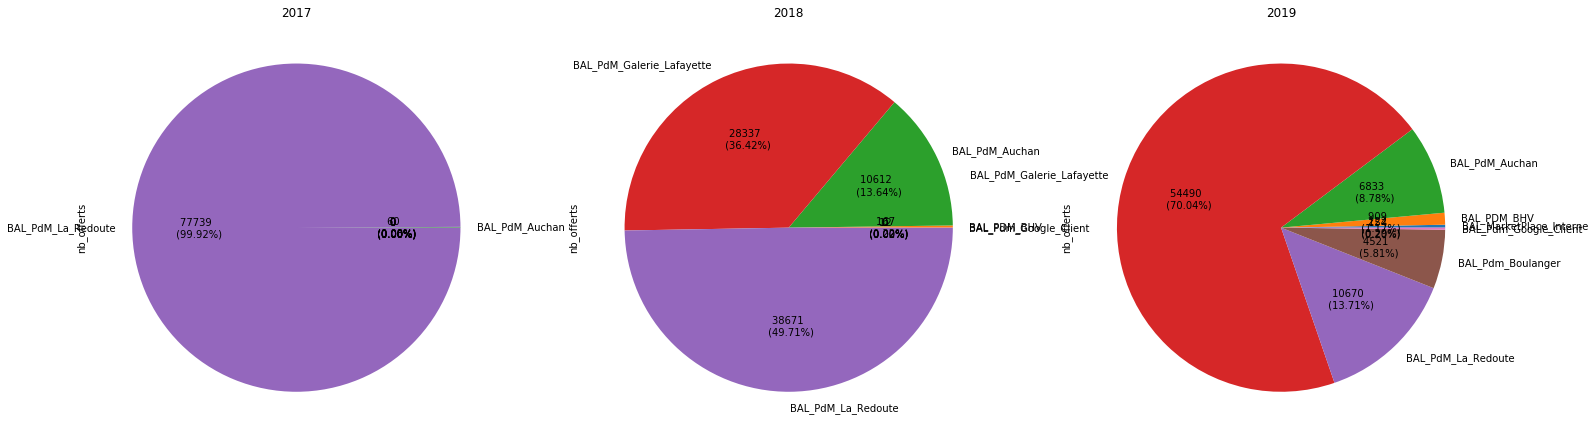

In [182]:
df = df_mois_BAL[df_mois_BAL['bal'].isin(bals_pdm)].groupby(['year', 'bal']).aggregate({'nb_offerts': sum})
df.reset_index(inplace=True)
df.head()
fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(25, 8))
for i, year in enumerate(years):
    ix = np.unravel_index(i, axes.shape) # compute an appropriate index (1d or 2d)
    df_plot = df[df.year == year][['bal', 'nb_offerts']].set_index('bal')
    df_plot.plot.pie(y='nb_offerts', title=year, autopct=make_autopct(df_plot), 
                     legend=False, ax=axes[ix])

In [169]:
df_mois_BAL.reset_index(inplace=True)
df = df_mois_BAL[df_mois_BAL['BAL'].isin(bals_pdm)].groupby(['année', 'BAL']).aggregate({'nb_emails_reçus': sum})
df.reset_index(inplace=True)
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
for i, year in enumerate(years):
    df_plot = df[df.année == year][['BAL', 'nb_emails_reçus']]
    fig.add_trace(go.Pie(labels=df_plot['BAL'], values=df_plot['nb_emails_reçus'], name=str(year),
                         title={'text': str(year)+'<br> ', 'font': {'size': 16}, 'position': "top center"}), 1, i+1)
fig.update_traces(textinfo='value+percent', textposition='inside')
fig.update_layout(title_text="Répartition des emails reçus par BAL de type PDM", title_x=0.5)
fig.show()

ValueError: cannot insert level_0, already exists

In [8]:
#Export du notebook en HTML
os.system('jupyter nbconvert --to html --template hidecode Trafic_emails_users.ipynb')

0